# Imports

In [1]:
import os, torch, random
import SimpleITK
import numpy as np
import matplotlib.pyplot as plt 
from torchvision import transforms
from torch.utils.data import DataLoader
import re
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from OASIS_2D.dataset import OASIS_Dataset

In [2]:
SEED = 2024

def seed_everything(seed):
    random.seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)

seed_everything(SEED)

## GPU

In [3]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


# Dataset

In [4]:
# https://pytorch.org/vision/stable/transforms.html
data_transforms = {
    'train': transforms.Compose([
        # Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] 
        # to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
        transforms.ToTensor(), 
        # transforms.RandomResizedCrop(224),
        transforms.Resize(224),
        # transforms.RandomHorizontalFlip(),
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(), # PIL Image or numpy.ndarray (H x W x C)
        transforms.Resize(224),
        # transforms.CenterCrop(224)
    ]),
}

In [5]:
train_dataset = OASIS_Dataset(
    train=True, seed=SEED, 
    transform=data_transforms['train'],
    vit=True
)
test_dataset = OASIS_Dataset(
    train=False, seed=SEED, 
    transform=data_transforms['test'],
    vit=True
)

batch_size = 8
train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True,
)

test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

Total 77, disease 37, healthy 40.             Unique patients 42.
Total 23, disease 13, healthy 10.             Unique patients 11.


# Model

[Getting attention scores out of vit model ](https://github.com/huggingface/pytorch-image-models/discussions/926)

In [6]:
from torchvision import models

# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
# https://pytorch.org/vision/main/models/vision_transformer.html
model = models.vision_transformer.vit_b_16(weights='DEFAULT')

# Here, we need to freeze all the network except the final layer. 
# We need to set requires_grad = False to freeze the parameters 
# so that the gradients are not computed in backward().
for param in model.parameters():
    param.requires_grad = False

In [7]:
model

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [8]:
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model.heads.head.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model.heads.head = torch.nn.Linear(num_ftrs, 2)

model = model.to(device)

# Train

In [9]:
from OASIS_2D.oasis import Experiment

result_dir = os.path.join('OASIS_2D', 'results', model._get_name())
exp = Experiment(result_dir=result_dir, device=device)

train_history = exp.train(
    model, train_dataloader=train_dataloader, 
    val_dataloader=test_dataloader,
    epochs=25, learning_rate=1e-3
)

Epoch 1/25
----------
Train loss: 6.6732 Acc: 0.5325
Val loss: 1.7047 Acc: 0.6522
Validation loss decreased (inf --> 1.704720).  Saving model ...

Epoch 2/25
----------
Train loss: 5.8976 Acc: 0.6623
Val loss: 1.3024 Acc: 1.0000
Validation loss decreased (1.704720 --> 1.302434).  Saving model ...

Epoch 3/25
----------
Train loss: 5.0479 Acc: 0.7143
Val loss: 1.2142 Acc: 0.8696
Validation loss decreased (1.302434 --> 1.214240).  Saving model ...

Epoch 4/25
----------
Train loss: 4.4071 Acc: 0.8312
Val loss: 1.0534 Acc: 1.0000
Validation loss decreased (1.214240 --> 1.053367).  Saving model ...

Epoch 5/25
----------
Train loss: 3.9550 Acc: 0.8571
Val loss: 1.1076 Acc: 0.8696
EarlyStopping counter: 1 out of 5

Epoch 6/25
----------
Train loss: 3.7723 Acc: 0.8831
Val loss: 0.9900 Acc: 0.9565
Validation loss decreased (1.053367 --> 0.989997).  Saving model ...

Epoch 7/25
----------
Train loss: 3.4881 Acc: 0.8831
Val loss: 1.0174 Acc: 0.9565
EarlyStopping counter: 1 out of 5

Epoch 8/25


In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

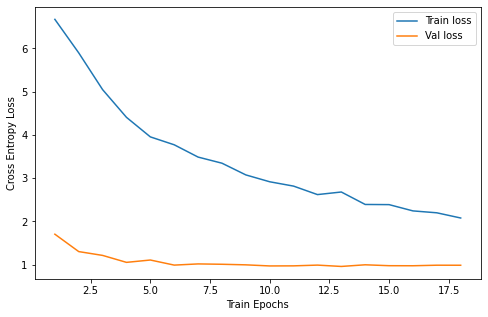

In [11]:
plt.figure(figsize=(8, 5))
plt.plot(train_history['epoch'], train_history['train_loss'], label='Train loss')
plt.plot(train_history['epoch'], train_history['val_loss'], label='Val loss')
plt.xlabel('Train Epochs')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.savefig(os.path.join(result_dir, 'train_history.jpg'), dpi=200)
plt.show()

# Test

In [12]:
train_result = exp.test(model, train_dataloader)
test_result = exp.test(model, test_dataloader)

Loss: 2.4289, Accuracy 0.9481, F1 0.9444, AUC 0.9878.
Loss: 0.9590, Accuracy 0.9130, F1 0.9231, AUC 0.9615.


In [13]:
import json

with open(os.path.join(result_dir, 'train.json'), 'w') as output_file:
    json.dump(train_result, output_file, indent=4)

In [14]:
with open(os.path.join(result_dir, 'test.json'), 'w') as output_file:
    json.dump(test_result, output_file, indent=4)